# Unsupervised Learning on the MNIST dataset 

In [8]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.examples.tutorials.mnist import input_data
% matplotlib inline

# 1. Loading the data set 

In [9]:
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 1.1 Plot a few examples

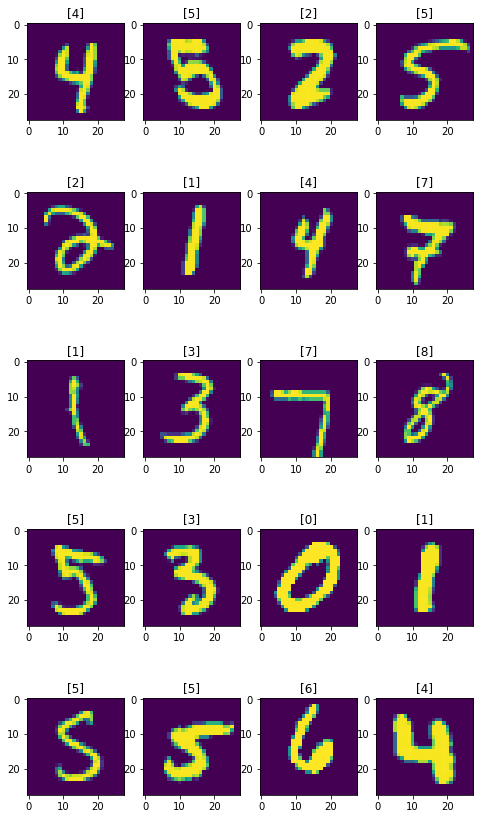

In [10]:
def show_examples(size, width):
    # Calc the depth needed
    depth = int(size/width)
    # Load the images and labels
    images, labels = mnist.test.next_batch(depth*width)
    # Config Subplot
    f, axarr = plt.subplots(depth, width)
    for d in range(depth):
        for i in range(width):
            axarr[d,i].imshow(images[d * width + i].reshape(28,28))
            # Fine the index where value is 1
            axarr[d,i].set_title(np.where(labels[d*width+i]==1)[0])
            axarr[d,i].set_axis_off
    f.set_size_inches(width*2, depth*3)
    return
show_examples(20,4)

### 1.2 Prep for test set embeddings

In [11]:
LOG_DIR = 'tmp/tb/1'

# 2. Modelling 

In [12]:
n_features = 28*28
# Four Layer the autoencoder
#dimensions = [512, 256, 128, 64, 2]
dimensions = [512, 256, 128, 64]
learning_rate = 1e-4

### 2.1 Define the graph

In [13]:
tf.reset_default_graph()


##
x = tf.placeholder(tf.float32, [None, n_features], name='input')

current_input = x
n_input = n_features

ws = [] # list of all the weights 

# Building the Encoder
for layer_i, n_output in enumerate(dimensions):
    #print('Creating weights with {} by {}' .format(n_input, n_output))
    layer_name = 'encode_layer' + str(layer_i)
    with tf.name_scope(layer_name):
        w = tf.Variable(tf.truncated_normal([n_input, n_output], stddev=0.1), tf.float32, name='w')
        h = tf.nn.relu(tf.matmul(current_input, w))
        # Tensorboard Recording
        tf.summary.histogram('weights', w)
        tf.summary.histogram('activation', h)
        ws.append(w)
        current_input = h
        n_input = n_output
        
    

z = tf.identity(current_input, 'inner')
## Test 
#embedding = tf.Variable(mnist.test.images, name = 'test_embedding')


## Building the Decoder 
wd = ws[::-1] # Reverse the weights 
dimensions_d = dimensions[::-1][1:] + [n_features]

for layer_i, n_output in enumerate(dimensions_d):
    layer_name = 'decode_layer' + str(layer_i)
    with tf.name_scope(layer_name):
        w = tf.transpose(wd[layer_i], name='w')
        h = tf.nn.relu(tf.matmul(current_input, w))
        # TB summary
        tf.summary.histogram('weights', w)
        tf.summary.histogram('activation', h)
        current_input = h
        n_input = n_output
    
    
y = current_input
y = tf.identity(y, 'output')


## Measure output performance and optimiser
with tf.name_scope('Cost'):
    cost = tf.reduce_mean(tf.squared_difference(x, y), 1)
    cost = tf.reduce_mean(cost)
    tf.summary.scalar('Cost', cost)
    
with tf.name_scope('Training'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### 2.2 Training

In [14]:
batch_size = 128
n_epoch = 5
epoch_cycle = 500
n_iter = n_epoch * epoch_cycle

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


#tf.summary.image('input_images', mnist.train.images, 10)
# Image must be a 4d tensor? what? 
#saver = tf.train.Saver([z])
merged_summary = tf.summary.merge_all()
writer = tf.summary.FileWriter(LOG_DIR)
writer.add_graph(sess.graph)

for it in range(n_iter+1):
    batch_x,_ = mnist.test.next_batch(batch_size)
    optimizer.run(feed_dict={x:batch_x})
    
    if it % epoch_cycle == 0:
        epoch_value = int(it/epoch_cycle)
        cost_value = cost.eval(feed_dict={x:batch_x})
        print('Epoch: {} Cost: {}' .format(epoch_value, cost_value))
        
    # Record variables and write to disk
    if it % 10 ==0:
        s = sess.run(merged_summary, feed_dict={x:batch_x})
        writer.add_summary(s, it)

Epoch: 0 Cost: 0.18830522894859314
Epoch: 1 Cost: 0.0434880293905735
Epoch: 2 Cost: 0.02912084572017193
Epoch: 3 Cost: 0.02431577816605568
Epoch: 4 Cost: 0.020580973476171494
Epoch: 5 Cost: 0.01844988390803337


# 3. Reporting

### 3.1  Cost of test set

In [15]:
test_x = mnist.test.images
test_cost = cost.eval(feed_dict={x:test_x})
print('Cost of test set: {}'.format(test_cost))
print('Test to Train ratio: {}'.format(test_cost/cost_value))

Cost of test set: 0.018090857192873955
Test to Train ratio: 0.9805404543876648


### 3.2 Visual Inspection

In [16]:
test_out = y.eval(feed_dict={x:test_x})

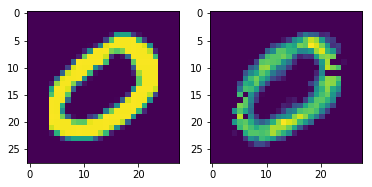

In [17]:
index = 60
plt.subplot(1,2,1)
plt.imshow(test_x[index].reshape(28,28))
plt.subplot(1,2,2)
plt.imshow(test_out[index].reshape(28,28))


### 3.3 64D Compress output for tensorboard

In [20]:
compressed = z.eval(feed_dict={x:mnist.test.images})
        
metadata = 'compressed_metadata.tsv'
test_labels = mnist.test.labels

with open(metadata, 'w') as metadata_file:
    for i, v in enumerate(test_labels):
        c = np.where(v==1)
        metadata_file.write('{}\n'.format(int(c[0])))
    

np.save('compressed_output', compressed)

#### 3.4 2D Compressed Visualisation

In [ ]:
sample = 1024
compressed = z.eval(feed_dict={x:mnist.test.images})
labels = mnist.test.labels
metadata = np.empty(len(labels))
for i, v in enumerate(labels):
    metadata[i] = np.where(v==1)[0]

    
for i in range(10):
    index = np.where(metadata==i)
    plt.scatter(compressed[index,0], compressed[index,1], label=str(i))
    
plt.legend()    
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

